In [1]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 12), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
%matplotlib inline
!pip install torchsummary


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
from pytorch_utils import dataset

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
train, test = dataset.cifar10()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Let us show some of the training images, for fun.



plane   dog  deer  deer


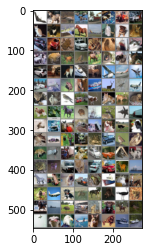

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
from torchsummary import summary
from pytorch_utils import models

net = models.CIFAR10_S7().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
              ReLU-6          [-1, 128, 32, 32]               0
       BatchNorm2d-7          [-1, 128, 32, 32]             256
           Dropout-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           4,096
           Conv2d-11           [-1, 32, 16, 16]             288
           Conv2d-12           [-1, 64, 16, 16]           2,048
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1, 64,

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []


EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, epoch, [], dict())
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    te_loss, te_acc = test.test(net, device, testloader)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.1824936866760254 Batch_id=390 Accuracy=47.81: 100%|██████████| 391/391 [00:15<00:00, 25.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3110, Accuracy: 5433/10000 (54.33%)

EPOCH: 1


Loss=0.6836704611778259 Batch_id=390 Accuracy=64.76: 100%|██████████| 391/391 [00:15<00:00, 25.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9165, Accuracy: 6767/10000 (67.67%)

EPOCH: 2


Loss=0.8443824052810669 Batch_id=390 Accuracy=71.96: 100%|██████████| 391/391 [00:15<00:00, 25.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8076, Accuracy: 7158/10000 (71.58%)

EPOCH: 3


Loss=0.6595108509063721 Batch_id=390 Accuracy=76.00: 100%|██████████| 391/391 [00:15<00:00, 25.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7612, Accuracy: 7397/10000 (73.97%)

EPOCH: 4


Loss=0.9085278511047363 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:15<00:00, 24.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7051, Accuracy: 7591/10000 (75.91%)

EPOCH: 5


Loss=0.48199135065078735 Batch_id=390 Accuracy=80.68: 100%|██████████| 391/391 [00:15<00:00, 24.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7005, Accuracy: 7618/10000 (76.18%)

EPOCH: 6


Loss=0.6332155466079712 Batch_id=390 Accuracy=82.24: 100%|██████████| 391/391 [00:15<00:00, 25.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6228, Accuracy: 7837/10000 (78.37%)

EPOCH: 7


Loss=0.41476649045944214 Batch_id=390 Accuracy=83.64: 100%|██████████| 391/391 [00:15<00:00, 24.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6193, Accuracy: 7920/10000 (79.20%)

EPOCH: 8


Loss=0.3797524869441986 Batch_id=390 Accuracy=84.76: 100%|██████████| 391/391 [00:15<00:00, 24.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5932, Accuracy: 7989/10000 (79.89%)

EPOCH: 9


Loss=0.5105353593826294 Batch_id=390 Accuracy=85.47: 100%|██████████| 391/391 [00:15<00:00, 24.99it/s]



Test set: Average loss: 0.5737, Accuracy: 8005/10000 (80.05%)



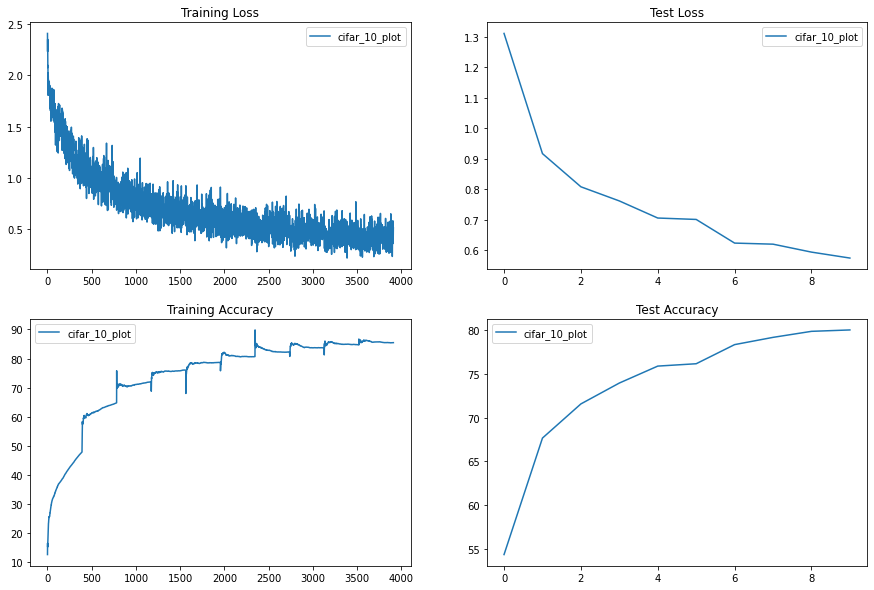

In [11]:
from pytorch_utils import utils

utils.plot_results(train_losses, train_acc, test_losses, test_acc)